*OCR, 이를 최소화*

* *False Positive (FP, 오탐) : 실제로 오류가 존재하지않지만, 오류라고 보고하는 경우*
  + *ex. 영수증에 존재하지 않는 항목이나 수치를 OCR이 잘못 감지하여 출력하는 경우*
* *False Negative (FN, 미탐) : 실제로 오류가 존재하지만, 오류가 없다고 보고하는 경우*
  + *ex. 실제로 존재하는 텍스트를 OCR이 놓쳐서 감지하지 못하는 경우*

***성능평가 지표 확인***

+ *IoU*
+ *WEM (Word based Exactly Matching)*
+ *1-NED (Normalized Edit Distance)*
+ *PopEval*
+ *Character Error Rate (CER)*
+ *Word Error Rate (WER)*


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### 1. Settings

In [2]:
import os
import sys

base_dir = "/content/gdrive/MyDrive/Workspace/Colab"
sys.path.append(base_dir)

src_dir = os.path.join(base_dir, "ocr")
%cd $src_dir

/content/gdrive/MyDrive/Workspace/Colab/ocr


In [3]:
!pip install -r requirements.txt > /dev/null

In [4]:
import getpass
from dotenv import load_dotenv

# .env 파일 로드
load_dotenv()

def get_env_variable(var_name, prompt_message) -> str:
    """
    환경 변수 가져오거나,
    없으면 사용자입력
    """
    value = os.getenv(var_name)
    if not value:
        value = getpass.getpass(prompt_message)

    return value

In [5]:
OCR_SECRET_KEY = get_env_variable("OCR_SECRET_KEY", "Enter your OCR_SECRET_KEY: ")
APIGW_URL = get_env_variable("APIGW_INVOKE_URL", "Enter your APIGW_INVOKE_URL: ")

if not OCR_SECRET_KEY:
    raise ValueError("OCR SECRET KEY not found in .env file.")
if not APIGW_URL:
    raise ValueError("APIGW INVOKE URL not found in .env file.")

In [6]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()
for file_name, file_content in uploaded.items():
    print(f"File name: {file_name}")

image_file = list(uploaded.keys())[0]

Saving Eval.jpg to Eval.jpg
File name: Eval.jpg


*bbox [x_min, y_min, width, height]*

In [7]:
gt_label_json = {

    "annotations": [
        {"id":1, "bbox": [165, 158, 53, 31], "text": "금액"},
        {"id":2, "bbox": [218, 160, 7.5, 23.5], "text": ":"},
        {"id":3, "bbox": [231, 155, 114, 52], "text": "10,000원"},
        {"id":4, "bbox": [348, 175, 96, 74], "text": "주문 번호"},
        {"id":5, "bbox": [445, 232, 120.5, 149], "text": "1234567890"}
    ]
}

In [8]:
dummy_pred_label_json = {

    "annotations": [
        {"id":1, "bbox": [165, 151, 63, 37.5], "text": "금액:"},
        {"id":3, "bbox": [231, 155, 114, 52], "text": "10,000원"},
        {"id":4, "bbox": [349, 178, 49, 41.5], "text": "주문"},
        {"id":5, "bbox": [445, 232, 120.5, 149], "text": "1234567890"}
    ]
}

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm
from PIL import Image

# 폰트 적용 - 글자(한글) 깨짐 방지
font_path = '../static/fonts/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)

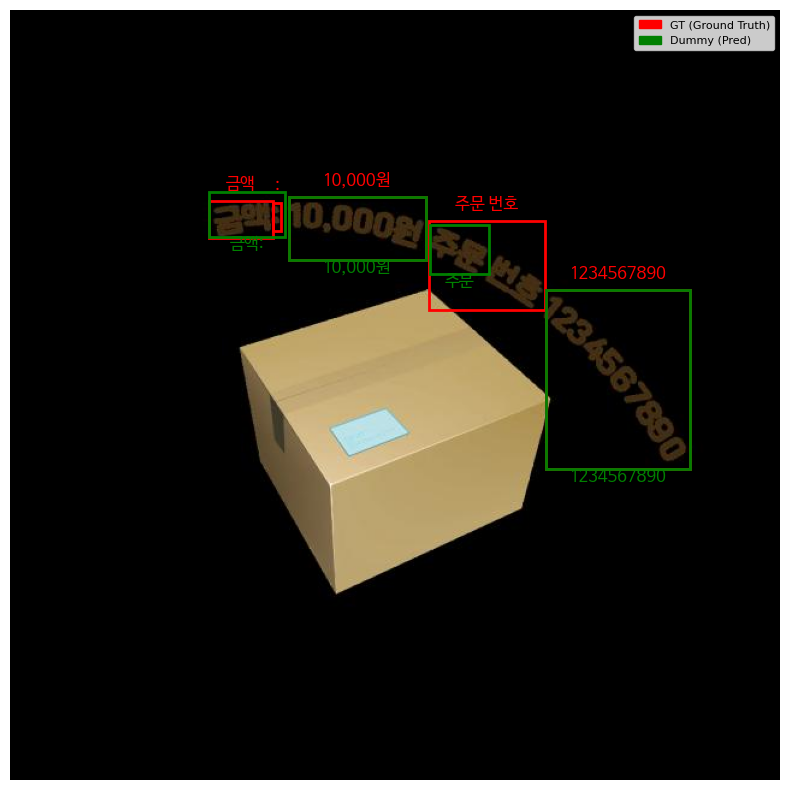

In [11]:
image = Image.open(image_file)

fig, ax = plt.subplots(1, figsize=(12, 10))
ax.imshow(image)

if image is not None:

    # GT bbox 및 text 표시
    for annotation in gt_label_json['annotations']:
        bbox = annotation['bbox']
        text = annotation['text']

        x_min, y_min, width, height = map(int, bbox)
        x_max = x_min + width
        y_max = y_min + height

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min + width / 2, y_min - 10, text, color='red', fontproperties=fontprop, ha='center')

    # Pred bbox 및 text 표시
    for annotation in dummy_pred_label_json['annotations']:
        bbox = annotation['bbox']
        text = annotation['text']

        x_min, y_min, width, height = map(int, bbox)
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min + width / 2, y_min + height + 10, text, color='green', fontproperties=fontprop, ha='center')

    handles = [
        patches.Patch(color='red', label='GT (Ground Truth)'),
        patches.Patch(color='green', label='Dummy (Pred)')
    ]
    ax.legend(handles=handles, loc='best', fontsize=8)

    plt.axis('off')
    plt.show()

In [13]:
def convert_bbox_format(bbox) -> list:
    """
    [좌상단, 우하단] 형태로 변환
    [x_min, y_min, width, height] to [x_min, y_min, x_max, y_max]
    """
    x_min, y_min, width, height = bbox
    x_max = x_min + width
    y_max = y_min + height
    return [x_min, y_min, x_max, y_max]

### **IoU (Intersection over Union)**

* 문자가 있는 bounding box를 얼마나 정확하게 예측했는지 (문자 검출)
* 정확히 텍스트를 예측해도, bbox 크기에 따라 IoU 성능이 낮아질 수 있음
* 단어에서 문자 하나만 빠져도 다른 단어이기에 postive가 아닌 FP로 처리해야 함

In [14]:
def IoU(box1, box2) -> float:
    """
    Calculate IoU

    :param box1: [x1, y1, x2, y2]
    :param box2: [x1, y1, x2, y2]
    :return: IoU value
    """
    # 각 좌표 추출
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # 교차 부분, 좌표 계산
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    # 교차 영역, 넓이 계산
    inter_width = max(0, x_inter_max - x_inter_min)
    inter_height = max(0, y_inter_max - y_inter_min)
    intersection_area = inter_width * inter_height

    # 각각의 박스 넓이 계산
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # IoU 계산
    iou = intersection_area / (box1_area + box2_area - intersection_area)
    return iou

In [16]:
gt_anno = {}
pred_anno = {}

for annotation in gt_label_json["annotations"]:
    gt_anno[annotation["id"]] = {
        "bbox": convert_bbox_format(annotation["bbox"]),
        "text": annotation["text"]
    }

for annotation in dummy_pred_label_json["annotations"]:
    pred_anno[annotation["id"]] = {
        "bbox": convert_bbox_format(annotation["bbox"]),
        "text": annotation["text"]
    }

In [17]:
for gt_id, gt in gt_anno.items():

    pred = pred_anno.get(gt_id)
    if pred:
        # IoU 계산
        iou = IoU(gt["bbox"], pred["bbox"])
        print(f"ID: {gt_id} | GT Text: {gt['text']} | Pred Text: {pred['text']} ==> IoU: {iou:.4f}")
    else:
        # pred가 없으면, IoU 0
        print("\n---------------------------------------------------------------")
        print(f"[Not Matched] ID: {gt_id} | GT Text: {gt['text']} | Pred Text: N/A ==> IoU: 0.0000")
        print("---------------------------------------------------------------\n")

ID: 1 | GT Text: 금액 | Pred Text: 금액: ==> IoU: 0.6766

---------------------------------------------------------------
[Not Matched] ID: 2 | GT Text: : | Pred Text: N/A ==> IoU: 0.0000
---------------------------------------------------------------

ID: 3 | GT Text: 10,000원 | Pred Text: 10,000원 ==> IoU: 1.0000
ID: 4 | GT Text: 주문 번호 | Pred Text: 주문 ==> IoU: 0.2862
ID: 5 | GT Text: 1234567890 | Pred Text: 1234567890 ==> IoU: 1.0000


### **WEM (Word based Exactly Matching)**

* 단어 단위
  + 문장이나 문맥 고려 X
* 글자 1개라도 틀리면 0점, 글자 모두 일치해야 100점
* 서로 있는 단어만을 비교
* tokenize에 따라, 계산결과가 달라짐


In [18]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [19]:
def WEM(gt_text, pred_text) -> float:
    """
    Calculate WEM

    :param gt_text:
    :param pred_text:
    :return: WEM value
    """
    # tokenize (단어 목록, 중복 제거)
    gt_words = set(word_tokenize(gt_text))
    pred_words = set(word_tokenize(pred_text))

    # 정확히 일치하는 단어들 찾기
    matched_words = gt_words.intersection(pred_words)
    num_matching = len(matched_words)

    # 전체 수
    total_words = len(gt_words)

    wem_score = num_matching / total_words if total_words != 0 else 0
    return wem_score

In [20]:
# ex1.
gt_text = "10000원"
pred_text = "10,000원"

wem_score = WEM(gt_text, pred_text)

print(f"WEM Score: {wem_score:.4f}")

WEM Score: 0.0000


In [21]:
# ex2. 공백 하나 차이로 -> 다른 단어로 인식
gt_text = "₩ 10,000"
pred_text = "₩10,000"

wem_score = WEM(gt_text, pred_text)

print(f"WEM Score: {wem_score:.4f}")

WEM Score: 0.0000


In [22]:
# ex3. 서로 있는 단어만을 비교 + 단어형태에 따라
# 토크나이저가 아래와 같이 분리하지 못하면, WEM은 0%
# gt {'금액'}
# pred {'금액', ':'}
gt_text = "금액"
pred_text = "금액:"

wem_score = WEM(gt_text, pred_text)

print(f"WEM Score: {wem_score:.4f}")

WEM Score: 1.0000


In [23]:
# ex4. 대/소문자 -> 다른 단어로 인식
gt_text = "WWW"
pred_text = "www"

wem_score = WEM(gt_text, pred_text)

print(f"WEM Score: {wem_score:.4f}")

WEM Score: 0.0000


In [24]:
# ex5. 단어의 순서나 위치 무시
gt_text = "123 www"
pred_text = "www 123"

wem_score = WEM(gt_text, pred_text)

print(f"WEM Score: {wem_score:.4f}")

WEM Score: 1.0000


In [25]:
for gt_id, gt in gt_anno.items():

    pred = pred_anno.get(gt_id)
    if pred:
        # WEM 계산
        wem_score = WEM(gt["text"], pred["text"])
        print(f"ID: {gt_id} | GT Text: {gt['text']} | Pred Text: {pred['text']} ==> WEM: {wem_score:.4f}")

ID: 1 | GT Text: 금액 | Pred Text: 금액: ==> WEM: 1.0000
ID: 3 | GT Text: 10,000원 | Pred Text: 10,000원 ==> WEM: 1.0000
ID: 4 | GT Text: 주문 번호 | Pred Text: 주문 ==> WEM: 0.5000
ID: 5 | GT Text: 1234567890 | Pred Text: 1234567890 ==> WEM: 1.0000


### **1-NED (Normalized Edit Distance)**

* 글자 기반
* 두 단어간 편집 거리(삽입, 교환, 삭제)를 측정한 뒤, 긴 단어의 길이로 정규화

$$1 - \frac{\text{편집 거리}}{\text{전체 문자열 길이}}$$


---


*편집 거리 예시*

+ *단순하게 두 문장 or 단어가 얼마나 다르냐를 평가하는 값*

```
# ex1. 편집 거리 4 (공백 삭제 2개, 90삭제 2개)
정답(GT): 주문 번호 1234567890
OCR 결과: 주문번호12345678

# ex2. 편집 거리 3 (대체 3개)
정답(GT): 한국어 테스트
OCR 결과: 한오오 태스트
```



In [26]:
import numpy as np
from nltk.metrics.distance import edit_distance
# import editdistance

In [29]:
def _edit_distance(str1, str2) -> float:
    """
    Levenshtein Distance
    """
    n, m = len(str1), len(str2)
    dp = np.zeros((n+1, m+1))

    for i in range(n+1):
        dp[i][0] = i
    for j in range(m+1):
        dp[0][j] = j

    for i in range(1, n+1):
        for j in range(1, m+1):
            if str1[i-1] == str2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(dp[i-1][j-1], dp[i-1][j], dp[i][j-1]) + 1

    return dp[n][m]

In [30]:
# ex1. 직접구현과 비교
print(edit_distance("주문 번호 1234567890", "주문번호12345678"))
print(_edit_distance("주문 번호 1234567890", "주문번호12345678"))

4
4.0


In [31]:
def norm_edit_distance(str1, str2) -> float:
    """
    Calculate NED

    :param str1:
    :param str2:
    :return: 1-NED
    """

    ed = edit_distance(str1, str2)
    return 1 - ed / max(len(str1), len(str2))

In [32]:
for gt_id, gt in gt_anno.items():

    pred = pred_anno.get(gt_id)
    if pred:
        # norm_ED 계산
        norm_ED = norm_edit_distance(gt["text"], pred["text"])
        print(f"ID: {gt_id} | GT Text: {gt['text']} | Pred Text: {pred['text']} ==> NED: {norm_ED:.4f}")
    else:
        # pred가 없으면, norm_ED 0
        print("\n---------------------------------------------------------------")
        print(f"[Not Matched] GT ID: {gt_id} | GT Text: {gt['text']} | Pred Text: N/A")
        print("---------------------------------------------------------------\n")

ID: 1 | GT Text: 금액 | Pred Text: 금액: ==> NED: 0.6667

---------------------------------------------------------------
[Not Matched] GT ID: 2 | GT Text: : | Pred Text: N/A
---------------------------------------------------------------

ID: 3 | GT Text: 10,000원 | Pred Text: 10,000원 ==> NED: 1.0000
ID: 4 | GT Text: 주문 번호 | Pred Text: 주문 ==> NED: 0.4000
ID: 5 | GT Text: 1234567890 | Pred Text: 1234567890 ==> NED: 1.0000


### **PopEval**

* 단어 단위가 아닌, 글자 단위로 ground truth와 prediction 글자를 비교하며 precision, recall을 평가하는 방법
* 겹치는 영역의 글자 중에서, 같은 글자(=맞춘 글자)를 하나씩 지워서 성능 측정
* Recall: 맞춘 글자수 / 정답 글자수
* Precision: 맞춘 글자수 / 예측한 글자수
* [naver/popeval](https://github.com/naver/popeval)

In [ ]:
!git clone https://github.com/naver/popeval.git /content/popeval

Cloning into '/content/popeval'...
remote: Enumerating objects: 766, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 766 (delta 8), reused 18 (delta 7), pack-reused 744 (from 1)
Receiving objects: 100% (766/766), 991.01 KiB | 10.77 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [33]:
def convert_to_8_coords(top_left, bottom_right) -> list:
    """
    [좌상단, 우하단] to [좌상단, 우상단, 우하단, 좌하단]
    """
    x1, y1 = top_left
    x2, y2 = bottom_right

    # 8개 좌표 계산
    coordinates = [
        x1, y1,  # 좌상단
        x2, y1,  # 우상단
        x2, y2,  # 우하단
        x1, y2   # 좌하단
    ]

    return coordinates

### **Character Error Rate (CER)**

*문자 수준, 예측의 정확도를 평가*
  + S: 교체된 문자 수 (Substitutions)
  + D: 삭제된 문자 수 (Deletions)
  + I: 삽입된 문자 수 (Insertions)
  + N: 참조 텍스트의 전체 문자 수

$$\text{CER} = \frac{S + D + I}{N}$$

In [34]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.7 MB/s eta 0:00:00


In [35]:
from jiwer import wer, cer

In [36]:
# ex1. 공백으로 인해 85%
gt_text = "123 www"
pred_text = "www 123"

error = cer(gt_text, pred_text)

print(f"CER 오류율: {error:.4f}")

CER 오류율: 0.8571


In [38]:
import editdistance

def calculate_cer(gt, pred) -> float:
    return editdistance.eval(gt, pred) / len(gt)

gt_text = "123 www"
pred_text = "www 123"

error = calculate_cer(gt_text, pred_text)
print(f"CER 오류율: {error:.4f}")

CER 오류율: 0.8571


### **Word Error Rate (WER)**

*단어 수준, 예측의 정확도를 평가*
  + S: 교체된 단어 수 (Substitutions)
  + D: 삭제된 단어 수 (Deletions)
  + I: 삽입된 단어 수 (Insertions)
  + N: 참조 텍스트에서의 단어 수

$$\text{WER} = \frac{S + D + I}{N}$$


In [39]:
# ex1. 단어 순서에 민감 (오류율 100%)
gt_text = "123 www"
pred_text = "www 123"

error = wer(gt_text, pred_text)

print(f"WER 오류율: {error:.4f}")

WER 오류율: 1.0000


In [40]:
import editdistance

def calculate_wer(gt, pred) -> float:
    gt_words = gt.split()
    pred_words = pred.split()
    return editdistance.eval(gt_words, pred_words) / len(gt_words)

gt_text = "123 www"
pred_text = "www 123"

error = calculate_wer(gt_text, pred_text)

print(f"WER 오류율: {error:.4f}")

WER 오류율: 1.0000
